In [2]:
# imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
plt.style.use('dark_background')

In [3]:
# get asap data
data_folder = Path.cwd().parent.parent.joinpath('data', 'external')
df_asap = pd.read_csv(Path(data_folder).joinpath('asap', 'region','SEN_asap_region.csv'), index_col = 0)

In [4]:
df_asap.head()

,region_name,variable_name,sensor_name,class_name,date,value,year,month,day,yearday
0,Kolda,Temperature,ECMWF,Rangeland during growing cycle,19890101,25.302,1989,1,1,1
1,Kolda,Temperature,ECMWF,Rangeland during growing cycle,19890111,26.047,1989,1,11,11
2,Kolda,Temperature,ECMWF,Rangeland during growing cycle,19890501,31.429,1989,5,1,121
3,Kolda,Temperature,ECMWF,Rangeland during growing cycle,19890511,32.047,1989,5,11,131
4,Kolda,Temperature,ECMWF,Rangeland during growing cycle,19890521,32.364,1989,5,21,141


In [5]:
# get IPC data
df_ipc = pd.read_csv(Path(data_folder).joinpath('ipc_current.csv'))

In [6]:
df_ipc

,adm1_name,adm2_name,datetime,population,phase_class,phase1,phase2,phase3,phase4,phase5,phase35
0,Kolda,Velingara,2014-01-01,289381.0,2.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0
1,Kolda,Kolda,2014-01-01,249271.0,2.0,184461.0,47361.0,17449.0,0.0,0.0,17449.0
2,Kolda,Medina Yoro Foulah,2014-01-01,134688.0,2.0,106404.0,21550.0,6734.0,0.0,0.0,6734.0
3,Louga,Louga,2014-01-01,387594.0,3.0,135658.0,174417.0,62015.0,15504.0,0.0,77519.0
4,Louga,Linguere,2014-01-01,258325.0,2.0,206660.0,36166.0,15500.0,0.0,0.0,15500.0
...,...,...,...,...,...,...,...,...,...,...,...
586,Thies,Thies,2020-09-01,829174.0,1.0,704798.0,124376.0,0.0,0.0,0.0,0.0
587,Thies,Tivaouane,2020-09-01,561428.0,1.0,505285.0,56143.0,0.0,0.0,0.0,0.0
588,Ziguinchor,Bignona,2020-09-01,324943.0,2.0,214462.0,90984.0,19497.0,0.0,0.0,19497.0
589,Ziguinchor,Oussouye,2020-09-01,62185.0,1.0,52235.0,8084.0,1866.0,0.0,0.0,1866.0


In [7]:
df_ipc['datetime'].unique()

array(['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
       '2018-01-01', '2019-01-01', '2020-01-01', '2014-09-01',
       '2015-09-01', '2016-09-01', '2017-09-01', '2018-09-01',
       '2019-09-01', '2020-09-01'], dtype=object)

### First start looking at the ratio between population share in different Phases

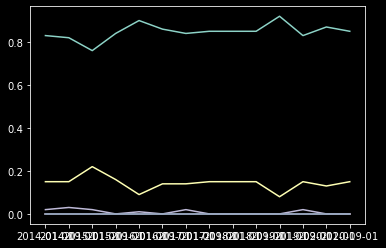

In [8]:
# for one region
temp = df_ipc[df_ipc['adm2_name'] == 'Thies'].copy()
temp.sort_values('datetime', inplace = True)
plt.plot(temp['datetime'], temp['phase1']/temp['population'])
plt.plot(temp['datetime'], temp['phase2']/temp['population'])
plt.plot(temp['datetime'], temp['phase3']/temp['population'])
plt.plot(temp['datetime'], temp['phase4']/temp['population'])
plt.plot(temp['datetime'], temp['phase5']/temp['population'])

#regions  = df_ipc['adm1_name'].unique()

We don't know yet, what to conclude from this.

We are probably going to predict something like softmax for 5 classes.

In [9]:
df_ipc.head()

,adm1_name,adm2_name,datetime,population,phase_class,phase1,phase2,phase3,phase4,phase5,phase35
0,Kolda,Velingara,2014-01-01,289381.0,2.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0
1,Kolda,Kolda,2014-01-01,249271.0,2.0,184461.0,47361.0,17449.0,0.0,0.0,17449.0
2,Kolda,Medina Yoro Foulah,2014-01-01,134688.0,2.0,106404.0,21550.0,6734.0,0.0,0.0,6734.0
3,Louga,Louga,2014-01-01,387594.0,3.0,135658.0,174417.0,62015.0,15504.0,0.0,77519.0
4,Louga,Linguere,2014-01-01,258325.0,2.0,206660.0,36166.0,15500.0,0.0,0.0,15500.0


In [10]:
temp = df_ipc.drop(['adm2_name', 'phase_class'], axis=1)
df_ipc_reg = temp.groupby(['adm1_name', 'datetime']).sum()

In [55]:
# severity version 2
df_ipc_reg['severity'] = (df_ipc_reg['phase1'] + df_ipc_reg['phase2']*2
                          + df_ipc_reg['phase3']*4 + df_ipc_reg['phase4']*8 +
                          df_ipc_reg['phase5']*16 )/ df_ipc_reg['population']

In [58]:
df_ipc_reg.head()

population    phase1   phase2  phase3  phase4  phase5  \
adm1_name datetime                                                            
Dakar     2014-01-01    358669.0  322802.0  35867.0     0.0     0.0     0.0   
          2014-09-01    490694.0  456345.0  34349.0     0.0     0.0     0.0   
          2015-01-01    490694.0  431811.0  49069.0  9814.0     0.0     0.0   
          2015-09-01    520960.0  442816.0  78144.0     0.0     0.0     0.0   
          2016-01-01    520960.0  458445.0  57306.0  5210.0     0.0     0.0   

                      phase35  severity  
adm1_name datetime                       
Dakar     2014-01-01      0.0  1.100000  
          2014-09-01      0.0  1.070001  
          2015-01-01   9814.0  1.160000  
          2015-09-01      0.0  1.150000  
          2016-01-01   5210.0  1.140005

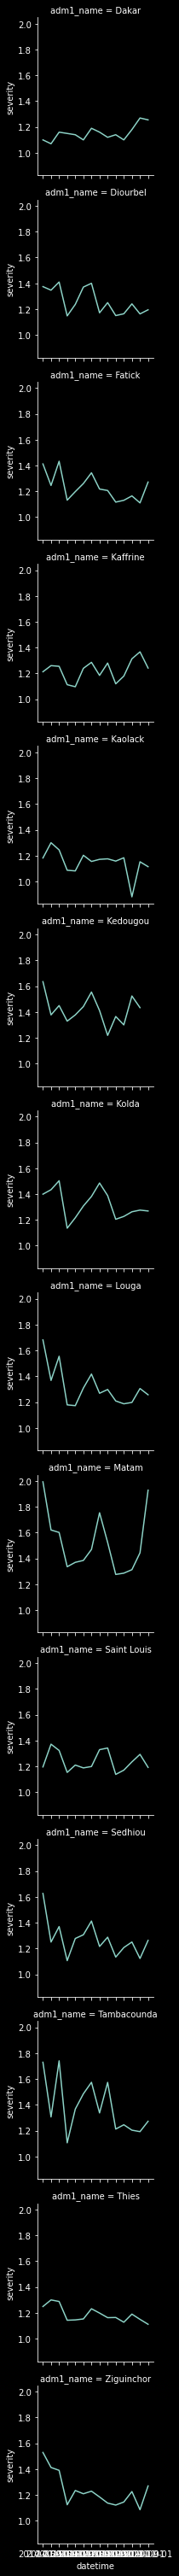

In [59]:
g = sns.FacetGrid(data = df_ipc_reg.reset_index(), row='adm1_name')

g.map(sns.lineplot, 'datetime','severity')

In [61]:
df_ipc_reg.xs('Kaolack')

,population,phase1,phase2,phase3,phase4,phase5,phase35,severity
datetime,,,,,,,,
2014-01-01,886755.0,760518.0,108919.0,17318.0,0.0,0.0,17318.0,1.181418
2014-09-01,960875.0,684436.0,270680.0,5759.0,0.0,0.0,5759.0,1.299682
2015-01-01,960874.0,783742.0,148420.0,28713.0,0.0,0.0,28713.0,1.244111
2015-09-01,1021657.0,933270.0,88387.0,0.0,0.0,0.0,0.0,1.086513
2016-01-01,1021657.0,959012.0,52428.0,10217.0,0.0,0.0,10217.0,1.081318
2016-09-01,1053537.0,869076.0,170012.0,14449.0,0.0,0.0,14449.0,1.202517
2017-01-01,1086465.0,923812.0,160049.0,2605.0,0.0,0.0,2605.0,1.154506
2017-09-01,1120405.0,954075.0,153782.0,12547.0,0.0,0.0,12547.0,1.170851
2018-01-01,1103141.0,943196.0,143408.0,16536.0,0.0,0.0,16536.0,1.174969


In [62]:
# drop other classes
# TODO: try to see different choices for different regions
df_crop = df_asap[df_asap['class_name'] == 'Crop'].copy()

In [63]:
# compute cumulative values until the checkpoint
checkpoints = ['0101', '0901']


In [64]:
df_crop.head()

,region_name,variable_name,sensor_name,class_name,date,value,year,month,day,yearday
0,Kolda,NDVI,MODIS,Crop,20011001,0.711,2001,10,1,274
1,Kolda,NDVI,MODIS,Crop,20011011,0.660,2001,10,11,284
2,Kolda,NDVI,MODIS,Crop,20011021,0.595,2001,10,21,294
3,Kolda,NDVI,MODIS,Crop,20011101,0.536,2001,11,1,305
4,Kolda,NDVI,MODIS,Crop,20011111,0.484,2001,11,11,315


In [65]:
# get the year day
checkpoints = [datetime.strptime(x, '%m%d').strftime('%j') for x in checkpoints]

In [66]:
df_crop['variable_name'].unique()


array(['NDVI', 'Temperature', 'NDVI - zscore', 'Rainfall',
       'SPI - 3 months'], dtype=object)

There are going to be two kinds of data
One, where we compute the cumulative value up to the dat and second one,
where we compute the probably the mean value.


<AxesSubplot:xlabel='yearday', ylabel='value'>

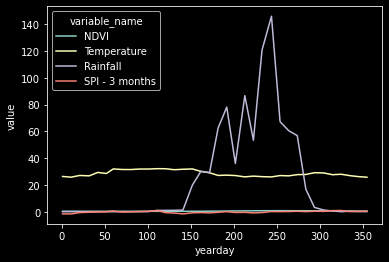

In [67]:
temp = df_crop[df_crop['region_name'] == 'Kolda'].copy()
temp = temp[temp['year'] == 2018]
sns.lineplot(data = temp, x = 'yearday', y = 'value', hue = 'variable_name')

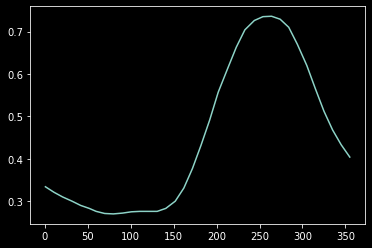

In [68]:
plt.plot(temp[temp['variable_name'] == 'NDVI']['yearday'],
         temp[temp['variable_name'] == 'NDVI']['value'])

In [69]:
df_ipc_reg.loc['Kolda']

,population,phase1,phase2,phase3,phase4,phase5,phase35,severity
datetime,,,,,,,,
2014-01-01,673340.0,499219.0,126787.0,47333.0,0.0,0.0,47333.0,1.399182
2014-09-01,662455.0,482922.0,125587.0,53946.0,0.0,0.0,53946.0,1.433879
2015-01-01,662455.0,461560.0,134649.0,66245.0,0.0,0.0,66245.0,1.503254
2015-09-01,722729.0,624528.0,98201.0,0.0,0.0,0.0,0.0,1.135875
2016-01-01,703677.0,601105.0,77703.0,24870.0,0.0,0.0,24870.0,1.216454
2016-09-01,725691.0,533772.0,176224.0,15696.0,0.0,0.0,15696.0,1.307725
2017-01-01,748452.0,525205.0,192090.0,31157.0,0.0,0.0,31157.0,1.381535
2017-09-01,772075.0,474330.0,259090.0,38655.0,0.0,0.0,38655.0,1.485775
2018-01-01,772075.0,544953.0,190830.0,36291.0,0.0,0.0,36291.0,1.388177


 When is the warning issued?

https://drive.google.com/file/d/1_W1yggkfuyiAG9OeE3-rFeaYVYKQZq_x/view
https://omdena-gpsdd-senegal.slack.com/archives/C01GZ7AA42C/p1609533337082500?thread_ts=1609522272.082400&cid=C01GZ7AA42C

Warnings counts are ploted here.
![warnings](plots/warnings.png)

As we can see, in the case of Cropland, most of warnings in Senegal happen

In [70]:
df_warn = pd.read_csv(Path(data_folder).joinpath('SEN_asap_warning.csv'))

In [71]:
df_warn.head()

,Unnamed: 0,asap0_id,asap0_name,date,hs_code,hs_name,comment,g1_w_crop,g1_w_range,g1_w_any
0,22,82,Senegal,2020-11-11,0,No hotspot,Not a hotspot country according to the latest ...,0,0,0
1,103,82,Senegal,2020-10-11,0,No hotspot,Not a hotspot country according to the latest ...,0,0,0
2,184,82,Senegal,2020-09-11,0,No hotspot,Not a hotspot country according to the latest ...,0,0,0
3,265,82,Senegal,2020-08-11,0,No hotspot,Rainfall in August has been below-average in c...,3,1,3
4,346,82,Senegal,2020-07-11,0,No hotspot,Planting of the main season millet and sorghum...,8,4,9


In [72]:
years = df_warn['date'].apply(lambda x: x[:4]).unique()
years

array(['2020', '2019', '2018', '2017', '2016'], dtype=object)

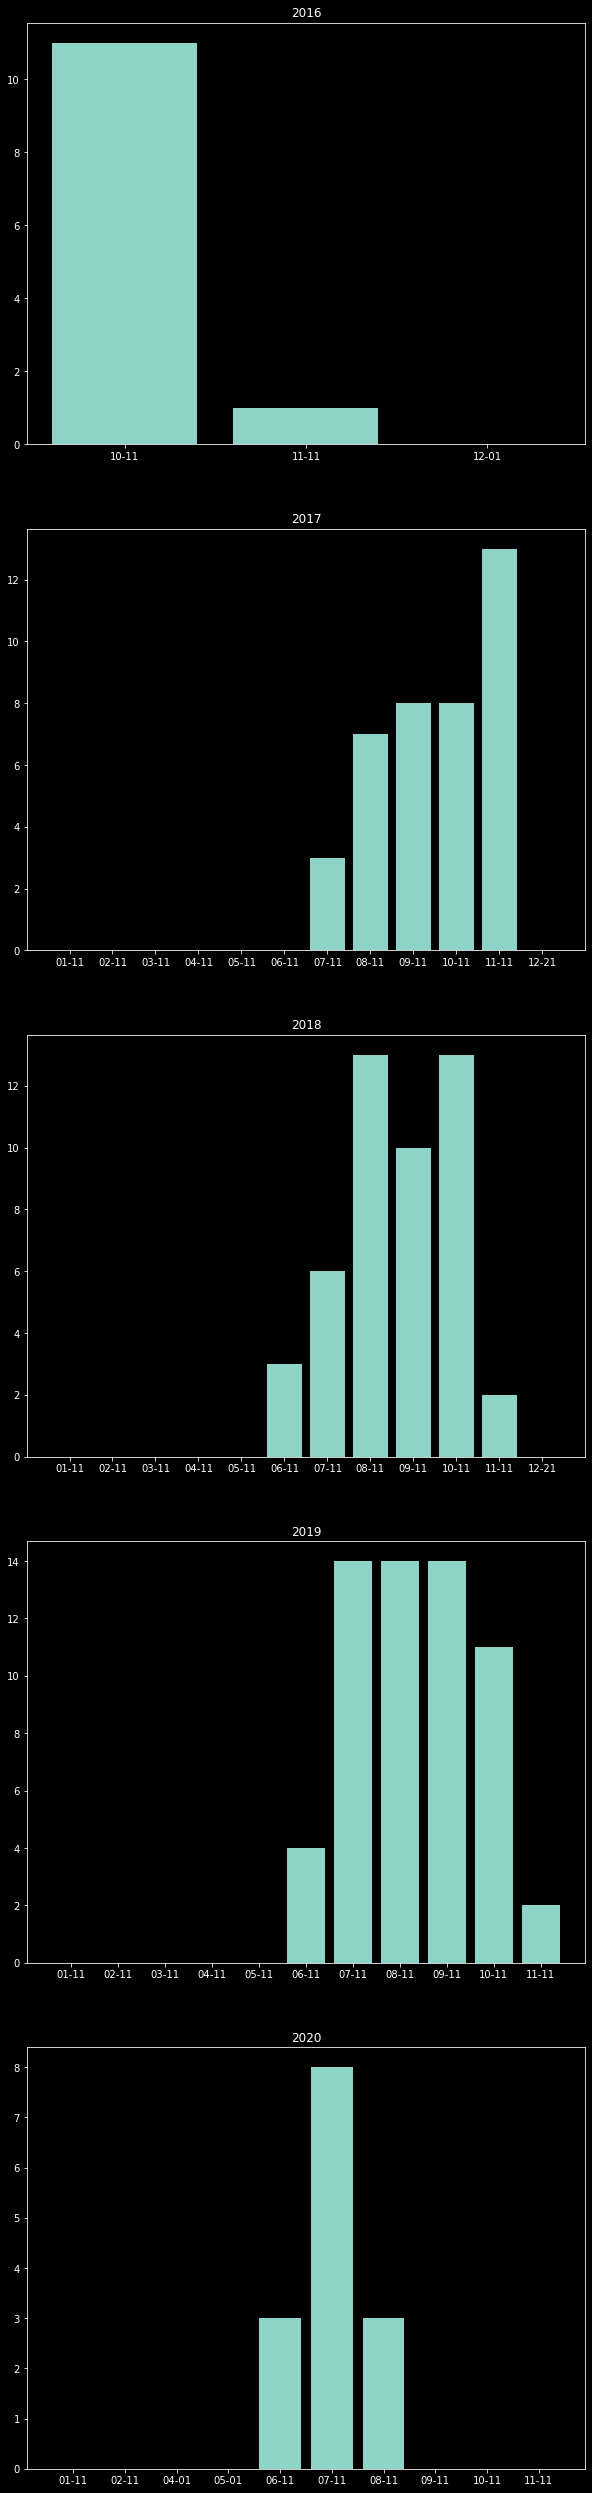

In [73]:
fig, ax = plt.subplots(5,1, figsize = (10, 45))

years.sort()
for i, y in enumerate(years):
    temp = df_warn[df_warn['date'].apply(lambda x: x[:4]) == str(y)].copy()
    temp.sort_values('date', inplace = True)
    ax[i].bar(temp['date'].apply(lambda x: x[5:]), temp['g1_w_crop'])
    ax[i].set_title(y)

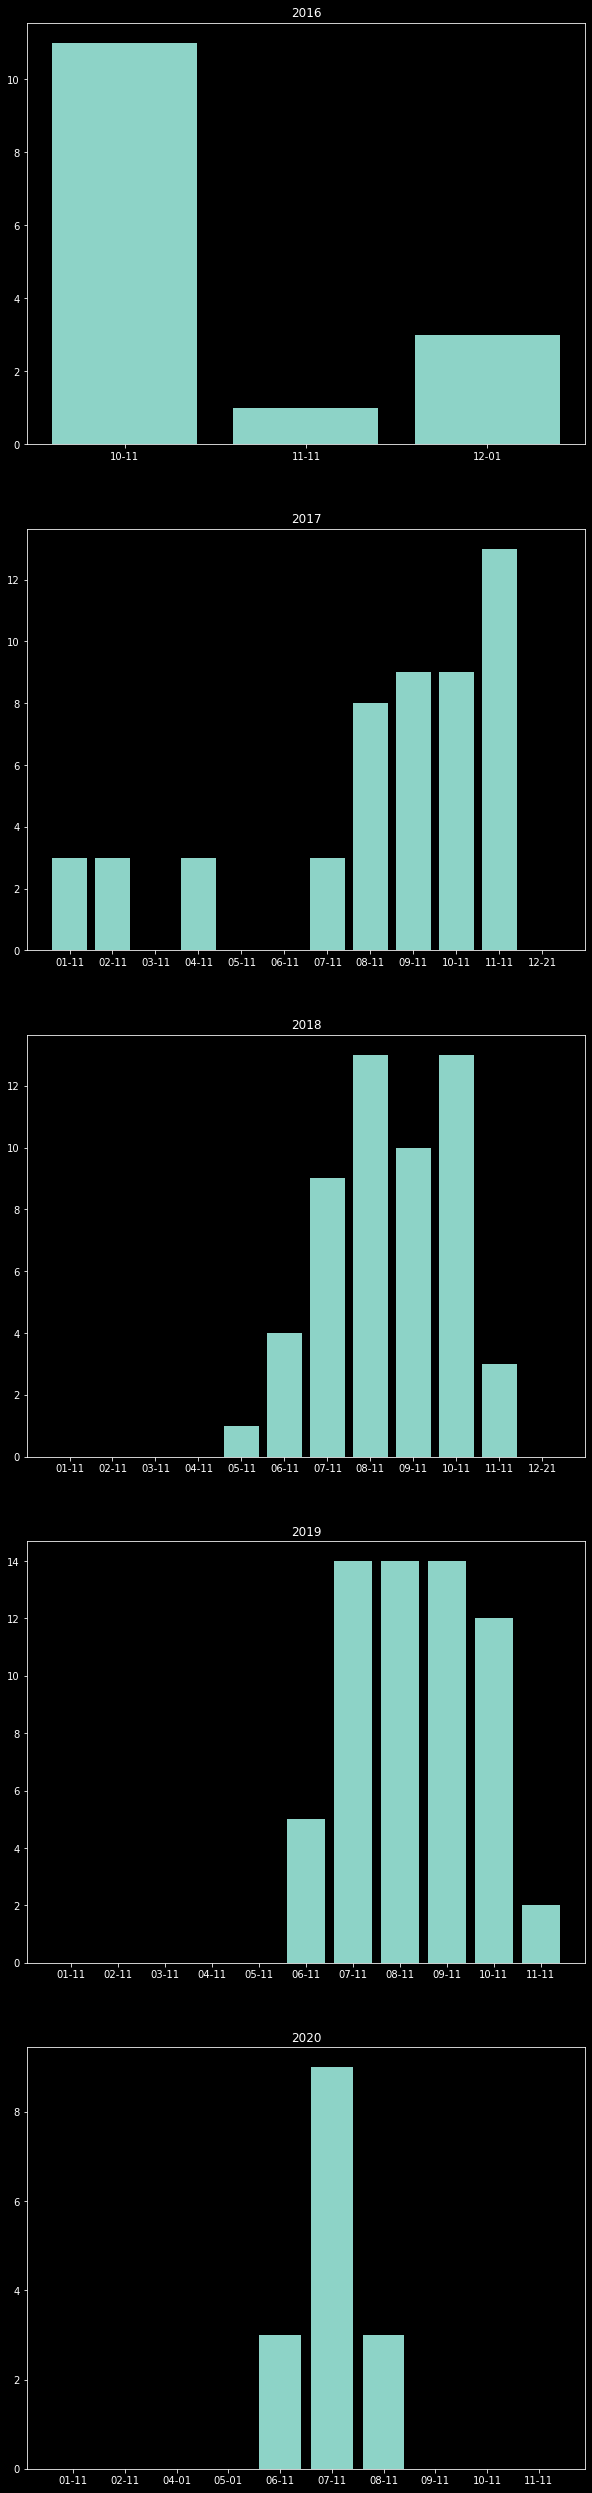

In [74]:
fig, ax = plt.subplots(5,1, figsize = (10, 45))

for i, y in enumerate(years):
    temp = df_warn[df_warn['date'].apply(lambda x: x[:4]) == str(y)].copy()
    temp.sort_values('date', inplace = True)
    ax[i].bar(temp['date'].apply(lambda x: x[5:]), temp['g1_w_any'])
    ax[i].set_title(y)

In [75]:
regions = df_crop['region_name'].unique()

In [76]:
# groupby month
df_warn = pd.read_csv(Path(data_folder).joinpath('SEN_asap_warning.csv'))

In [77]:
# lets add the year and month
df_warn['date'].unique()

array(['2020-11-11', '2020-10-11', '2020-09-11', '2020-08-11',
       '2020-07-11', '2020-06-11', '2020-05-01', '2020-04-01',
       '2020-02-11', '2020-01-11', '2019-11-11', '2019-10-11',
       '2019-09-11', '2019-08-11', '2019-07-11', '2019-06-11',
       '2019-05-11', '2019-04-11', '2019-03-11', '2019-02-11',
       '2019-01-11', '2018-12-21', '2018-11-11', '2018-10-11',
       '2018-09-11', '2018-08-11', '2018-07-11', '2018-06-11',
       '2018-05-11', '2018-04-11', '2018-03-11', '2018-02-11',
       '2018-01-11', '2017-12-21', '2017-11-11', '2017-10-11',
       '2017-09-11', '2017-08-11', '2017-07-11', '2017-06-11',
       '2017-05-11', '2017-04-11', '2017-03-11', '2017-02-11',
       '2017-01-11', '2016-12-01', '2016-11-11', '2016-10-11'],
      dtype=object)

In [78]:
df_warn.sort_values('date', inplace=True)
df_warn['date2'] = df_warn['date'].apply(lambda x: x[:-3])
df_warn.head(2)

,Unnamed: 0,asap0_id,asap0_name,date,hs_code,hs_name,comment,g1_w_crop,g1_w_range,g1_w_any,date2
47,3780,82,Senegal,2016-10-11,0,No hotspot,NDVI deficits in some regions (Tambacounda and...,11,9,11,2016-10
46,3701,82,Senegal,2016-11-11,0,No hotspot,"No hotspot at national level, but some low veg...",1,0,1,2016-11


In [79]:
df_warn['year'] = df_warn['date'].apply(lambda x: int(x[:4]))
df_warn['month'] = df_warn['date'].apply(lambda x: (int(x[5:7])))
df_warn.head(2)

,Unnamed: 0,asap0_id,asap0_name,date,hs_code,hs_name,comment,g1_w_crop,g1_w_range,g1_w_any,date2,year,month
47,3780,82,Senegal,2016-10-11,0,No hotspot,NDVI deficits in some regions (Tambacounda and...,11,9,11,2016-10,2016,10
46,3701,82,Senegal,2016-11-11,0,No hotspot,"No hotspot at national level, but some low veg...",1,0,1,2016-11,2016,11


In [80]:
df_warn.drop(['hs_name', 'comment', 'Unnamed: 0', 'asap0_id',
              'asap0_name', 'hs_code'],
             axis = 1,
             inplace = True)

In [81]:
df_warn.head(2)


,date,g1_w_crop,g1_w_range,g1_w_any,date2,year,month
47,2016-10-11,11,9,11,2016-10,2016,10
46,2016-11-11,1,0,1,2016-11,2016,11


In [82]:
temp = df_warn[['year', 'month', 'g1_w_crop']].copy()


In [83]:
temp = temp[temp['year'] != '2016']

[]

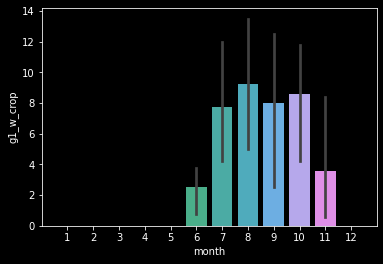

In [84]:
temp.sort_values('month', inplace=True)
sns.barplot(data = temp, x = 'month', y = 'g1_w_crop',)

plt.plot()

We have ground truth from two time spans:
- Sep - Dec
- Jan - May

Most warnings are issued in months from Jun-November, this is when an anomaly happens.
The outcome might onset with a delay. Lets not separate the data, and look at the season
from the day 100 (approximately from May) and we will try to perdict the state
in Jan - May next year.

In [85]:
df_ipc_reg.head(2)

population    phase1   phase2  phase3  phase4  phase5  \
adm1_name datetime                                                            
Dakar     2014-01-01    358669.0  322802.0  35867.0     0.0     0.0     0.0   
          2014-09-01    490694.0  456345.0  34349.0     0.0     0.0     0.0   

                      phase35  severity  
adm1_name datetime                       
Dakar     2014-01-01      0.0  1.100000  
          2014-09-01      0.0  1.070001

In [86]:
# lets look at a single region
region = 'Kolda'
y = df_ipc_reg.xs(region)

In [87]:
y.sort_index(inplace=True)

In [88]:
df_crop = df_crop[['region_name', 'variable_name', 'value', 'year', 'yearday']]

df_crop.head()

,region_name,variable_name,value,year,yearday
0,Kolda,NDVI,0.711,2001,274
1,Kolda,NDVI,0.660,2001,284
2,Kolda,NDVI,0.595,2001,294
3,Kolda,NDVI,0.536,2001,305
4,Kolda,NDVI,0.484,2001,315


In [89]:
df_crop = df_crop.pivot(index = ['region_name', 'year', 'yearday'], columns='variable_name',
              values = 'value')

In [90]:
df_crop.reset_index(inplace=True)


In [91]:
df_crop = df_crop[(df_crop['year'] >= 2012) & (df_crop['year'] <=2020)]

In [92]:
df_crop.drop('NDVI - zscore', axis=1, inplace=True)
df_crop['region_name'] = df_crop['region_name'].replace('Saint louis', 'Saint Louis')

In [93]:
df_crop



variable_name,region_name,year,yearday,NDVI,Rainfall,SPI - 3 months,Temperature
828,Dakar,2012,1,0.309,0.389,-1.097,24.027
829,Dakar,2012,11,0.300,0.000,-0.894,24.118
830,Dakar,2012,21,0.290,0.471,0.027,21.118
831,Dakar,2012,32,0.281,0.000,0.255,22.117
832,Dakar,2012,42,0.272,0.000,0.255,20.048
...,...,...,...,...,...,...,...
16081,Ziguinchor,2020,285,0.714,42.980,2.338,27.555
16082,Ziguinchor,2020,295,0.703,2.215,1.978,28.806
16083,Ziguinchor,2020,306,0.688,1.121,1.427,28.979
16084,Ziguinchor,2020,316,0.668,0.004,1.814,27.570


In [94]:
start_season_day = 100
for i, row in df_crop.iterrows():
    y = int(row['year'])
    d = row['yearday']
    df_crop.loc[i,'season_year'] = y if d > start_season_day else y-1
    df_crop.loc[i, 'season_day'] = d-100 if d>start_season_day \
        else 365 - start_season_day+d

In [95]:
df_crop.head()

variable_name,region_name,year,yearday,NDVI,Rainfall,SPI - 3 months,Temperature,season_year,season_day
828,Dakar,2012,1,0.309,0.389,-1.097,24.027,2011.0,266.0
829,Dakar,2012,11,0.300,0.000,-0.894,24.118,2011.0,276.0
830,Dakar,2012,21,0.290,0.471,0.027,21.118,2011.0,286.0
831,Dakar,2012,32,0.281,0.000,0.255,22.117,2011.0,297.0
832,Dakar,2012,42,0.272,0.000,0.255,20.048,2011.0,307.0


## Linear regression

$$y(w,x) = w_0 + w_1x_1 + ... w_px_p$$

In [96]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [101]:
df_crop['region_name'].unique()

array(['Dakar', 'Diourbel', 'Fatick', 'Kaffrine', 'Kaolack', 'Kedougou',
       'Kolda', 'Louga', 'Matam', 'Saint Louis', 'Sedhiou', 'Tambacounda',
       'Thies', 'Ziguinchor'], dtype=object)

In [102]:
df_ipc_reg.reset_index()['adm1_name'].unique()


array(['Dakar', 'Diourbel', 'Fatick', 'Kaffrine', 'Kaolack', 'Kedougou',
       'Kolda', 'Louga', 'Matam', 'Saint Louis', 'Sedhiou', 'Tambacounda',
       'Thies', 'Ziguinchor'], dtype=object)

x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.38817731 1.22690165 1.2758653 ]
Pred: [1.35155231 1.36206727 1.34348071]
MSE: 0.008060992579022262


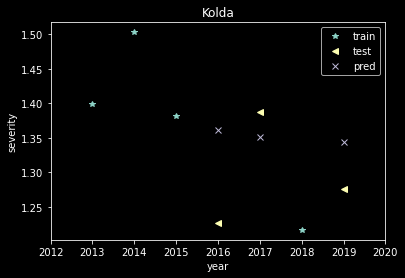

In [118]:
def predict(region='Kolda',
            df_gt=df_ipc_reg,
            df_var=df_crop,
            model_name='linreg',
            plot=True,
            **kwargs
            ):
    y = df_gt.xs(region).copy()
    y.reset_index(inplace=True)
    y = y[y['datetime'].apply(lambda x: x[5:7]) == '01']
    y = y['severity'].to_numpy()

    dict_x = {}
    df_var = df_var[df_var['region_name'] == region]
    for i in range(2013, 2020):
        temp = df_var[df_var['season_year'].apply(lambda x: int(x))== i]
        temp = temp[['NDVI', 'Rainfall', 'SPI - 3 months', 'Temperature']]
        temp = temp.to_numpy()
        dict_x[str(i)] = temp

    x = np.stack([xx for xx in dict_x.values()])

    print('x.shape: ', x.shape)
    print('y.shape: ', y.shape)


    x = np.nan_to_num(x, nan=0)
    # get the shuffle
    idx = np.arange(0,y.shape[0])
    years = np.arange(2013, 2020)

    reshape = True
    if reshape:
        if len(x.shape) == 3:
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])

    np.random.seed(42)
    np.random.shuffle(idx)

    years_s = years[idx]

    # split
    split = int(np.floor(0.7*len(years)))
    # shuffle
    x = x[idx,:]
    X_train, X_test = x[:split,:], x[split:,:]
    y_train, y_test = y[:split], y[split:]
    years_train = years_s[:split]
    years_test = years_s[split:]

    # rescale:
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # select model
    if model_name == 'linreg':
        regr = linear_model.LinearRegression()
        regr.fit(X_train_scaled, y_train)

        pred = regr.predict(X_test_scaled)
    elif model_name == 'randomforest':
        if 'max_depth' in kwargs.keys():
            max_depth = kwargs['max_depth']
        else:
            max_depth = 10
        regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
        regr.fit(X_train_scaled, y_train)
        pred = regr.predict(X_test_scaled)
    else:
        print('Model_name does not match.')

    mse = mean_squared_error(y_test, pred)
    print(f'True: {y_test}')
    print(f'Pred: {pred}')
    print(f'MSE: {mse}')

    if plot:
        fig, ax = plt.subplots(1,1)
        ax.plot(years_train, y_train, '*', label = 'train')
        ax.plot(years_test, y_test, '<', label = 'test')
        ax.plot(years_test, pred, 'x', label = 'pred')
        ax.set_xlim(2012, 2020)
        ax.legend()
        ax.set_title(region)
        ax.set_xlabel('year')
        _ = ax.set_ylabel('severity')
    return {'region': region,
            'years_train': years_train,
            'years_test': years_test,
            "y_test": y_test,
            'pred': pred,
            'y_train': y_train,
            'mse': mse,
            'regr': regr}



res = predict(model_name='randomforest')

x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.38817731 1.22690165 1.2758653 ]
Pred: [1.28677845 1.34834483 1.2629377 ]
MSE: 0.008399099153163508


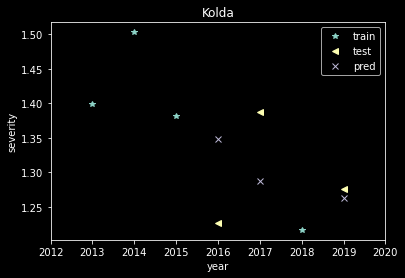

In [104]:
res = predict(model_name='linreg')

In [109]:
regions = df_crop['region_name'].unique()


In [110]:
i = 0
res = {}
for reg in regions:
    print(f'Predicting region {reg}')
    res[reg] = predict(region=reg, plot=False)

Predicting region Dakar
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.12       1.1000007  1.26956816]
Pred: [1.15381671 1.16413928 1.1617438 ]
MSE: 0.005627806342026862
Predicting region Diourbel
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.25047742 1.16412013 1.16310541]
Pred: [1.35058948 1.32508854 1.30093683]
MSE: 0.01831025141812061
Predicting region Fatick
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.20614935 1.13021538 1.11002712]
Pred: [1.33095276 1.32576129 1.25394256]
MSE: 0.02484191575829553
Predicting region Kaffrine
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.28035413 1.17945952 1.36731052]
Pred: [1.13218329 1.19515476 1.21444573]
MSE: 0.015189526864466655
Predicting region Kaolack
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.17496857 1.18324889 1.15211469]
Pred: [1.09364457 1.16459638 1.18793465]
MSE: 0.0027481927093280546
Predicting region Kedougou
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.41060445 1.36459639 1.52336586]
Pred: [1.39282006 1.46007743 0.88943075]
MSE: 0.

In [111]:
res.keys()

dict_keys(['Dakar', 'Diourbel', 'Fatick', 'Kaffrine', 'Kaolack', 'Kedougou', 'Kolda', 'Louga', 'Matam', 'Saint Louis', 'Sedhiou', 'Tambacounda', 'Thies', 'Ziguinchor'])

### Visualize predictions

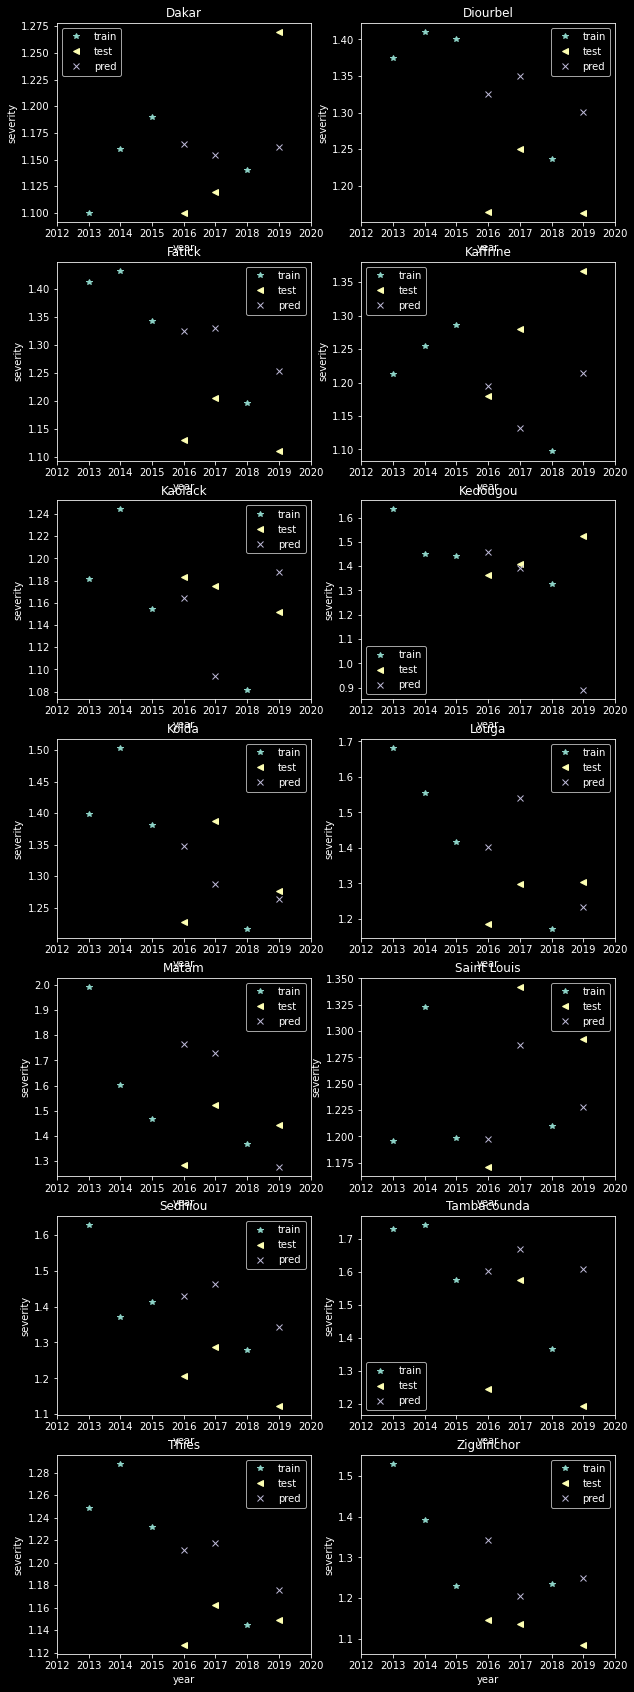

In [113]:
def plot_predictions(res):
    fig, axs = plt.subplots(7,2,figsize=(10,30))
    axs = axs.flatten()

    i = 0
    for key, temp in res.items():
        ax = axs[i]
        years_train = temp['years_train']
        years_test = temp['years_test']
        y_train = temp['y_train']
        y_test = temp['y_test']
        pred = temp['pred']

        ax.plot(years_train, y_train, '*', label = 'train')
        ax.plot(years_test, y_test, '<', label = 'test')
        ax.plot(years_test, pred, 'x', label = 'pred')
        #intercept = temp['intercept_']
        #ax.plot([2013, 2019], [intercept, intercept], '--',
        #        label = 'intercept')
        ax.set_xlim(2012, 2020)
        ax.legend()
        ax.set_title(key)
        ax.set_xlabel('year')
        _ = ax.set_ylabel('severity')
        i +=1

plot_predictions(res)

Predicting region Dakar
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.12       1.1000007  1.26956816]
Pred: [1.14200051 1.15239973 1.15139974]
MSE: 0.00573115174276444
Predicting region Diourbel
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.25047742 1.16412013 1.16310541]
Pred: [1.34158949 1.35383671 1.34618064]
MSE: 0.025936777139906497
Predicting region Fatick
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.20614935 1.13021538 1.11002712]
Pred: [1.32535174 1.33859847 1.32082527]
MSE: 0.03402286106655874
Predicting region Kaffrine
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.28035413 1.17945952 1.36731052]
Pred: [1.18971318 1.19555069 1.19645035]
MSE: 0.012555968309636352
Predicting region Kaolack
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.17496857 1.18324889 1.15211469]
Pred: [1.1503424  1.15894481 1.16951976]
MSE: 0.0005000243528053903
Predicting region Kedougou
x.shape:  (7, 36, 4)
y.shape:  (7,)
True: [1.41060445 1.36459639 1.52336586]
Pred: [1.48143834 1.45046127 1.43597483]
MSE: 0.

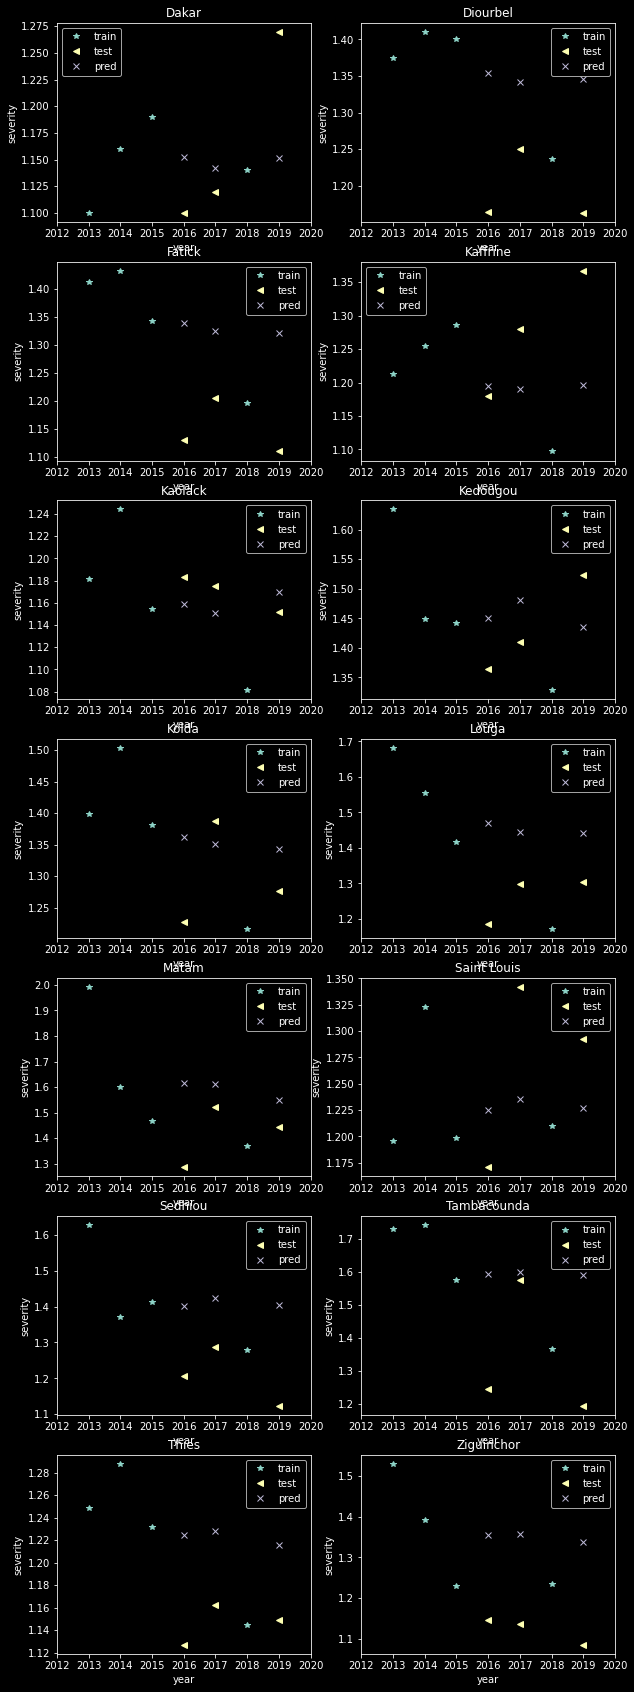

In [119]:
i = 0
res = {}
for reg in regions:
    print(f'Predicting region {reg}')
    res[reg] = predict(region=reg, plot=False, model_name='randomforest',
                       max_depth=20)

plot_predictions(res)



### Show regression parameters

In [52]:
temp = res['Dakar']

In [53]:
temp['coef_'].shape

KeyError: 'coef_'

In [54]:
coefs = np.empty((14, 144))
i = 0
for key, result in res.items():
    coefs[i,:] = result['coef_']
    i +=1

KeyError: 'coef_'

Text(0.5, 1.0, 'LinReg coeffs')

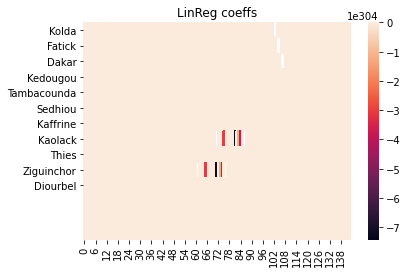

In [55]:
# show heatmap of coefficients
ax = plt.axes()
sns.heatmap(coefs, yticklabels=res.keys(), ax = ax)
ax.set_title('LinReg coeffs')

## TODO for Saturday
- region onehot and compare results
- add food waste
- add prices (in any way)
- Faiz send IPC cadre harmonise
- Ece ASAP data
-




In [56]:
df_crop.head()

variable_name,region_name,year,yearday,NDVI,Rainfall,SPI - 3 months,Temperature,season_year,season_day
828,Dakar,2012,1,0.309,0.389,-1.097,24.027,2011.0,266.0
829,Dakar,2012,11,0.300,0.000,-0.894,24.118,2011.0,276.0
830,Dakar,2012,21,0.290,0.471,0.027,21.118,2011.0,286.0
831,Dakar,2012,32,0.281,0.000,0.255,22.117,2011.0,297.0
832,Dakar,2012,42,0.272,0.000,0.255,20.048,2011.0,307.0


In [57]:
df_x = pd.concat([df_crop, pd.get_dummies(df_crop['region_name'])], axis=1)

In [58]:
df_ipc_reg.reset_index(inplace=True)
df_y = pd.concat([df_ipc_reg, pd.get_dummies(df_ipc_reg['adm1_name'])], axis=1)


In [61]:
df_x

,region_name,year,yearday,NDVI,Rainfall,SPI - 3 months,Temperature,season_year,season_day,Dakar,...,Kaolack,Kedougou,Kolda,Louga,Matam,Saint Louis,Sedhiou,Tambacounda,Thies,Ziguinchor
828,Dakar,2012,1,0.309,0.389,-1.097,24.027,2011.0,266.0,1,...,0,0,0,0,0,0,0,0,0,0
829,Dakar,2012,11,0.300,0.000,-0.894,24.118,2011.0,276.0,1,...,0,0,0,0,0,0,0,0,0,0
830,Dakar,2012,21,0.290,0.471,0.027,21.118,2011.0,286.0,1,...,0,0,0,0,0,0,0,0,0,0
831,Dakar,2012,32,0.281,0.000,0.255,22.117,2011.0,297.0,1,...,0,0,0,0,0,0,0,0,0,0
832,Dakar,2012,42,0.272,0.000,0.255,20.048,2011.0,307.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16081,Ziguinchor,2020,285,0.714,42.980,2.338,27.555,2020.0,185.0,0,...,0,0,0,0,0,0,0,0,0,1
16082,Ziguinchor,2020,295,0.703,2.215,1.978,28.806,2020.0,195.0,0,...,0,0,0,0,0,0,0,0,0,1
16083,Ziguinchor,2020,306,0.688,1.121,1.427,28.979,2020.0,206.0,0,...,0,0,0,0,0,0,0,0,0,1
16084,Ziguinchor,2020,316,0.668,0.004,1.814,27.570,2020.0,216.0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
df_y['month'] = df_y['datetime'].apply(lambda x: x[5:7])

In [68]:
df_y = df_y[df_y['month'] == '01']

In [69]:
df_y.head()

,adm1_name,datetime,population,phase1,phase2,phase3,phase4,phase5,phase35,severity,...,Kedougou,Kolda,Louga,Matam,Saint Louis,Sedhiou,Tambacounda,Thies,Ziguinchor,month
0,Dakar,2014-01-01,358669.0,322802.0,35867.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,01
2,Dakar,2015-01-01,490694.0,431811.0,49069.0,9814.0,0.0,0.0,9814.0,0.020000,...,0,0,0,0,0,0,0,0,0,01
4,Dakar,2016-01-01,520960.0,458445.0,57306.0,5210.0,0.0,0.0,5210.0,0.010001,...,0,0,0,0,0,0,0,0,0,01
6,Dakar,2017-01-01,552025.0,469221.0,71763.0,11040.0,0.0,0.0,11040.0,0.019999,...,0,0,0,0,0,0,0,0,0,01
8,Dakar,2018-01-01,552025.0,485782.0,66243.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,01
